In [1]:
## -- Set Device-Agnostic code --
import torch
print(f"ℹ️ Cuda available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    get_ipython().run_line_magic('load_ext', 'cuml.accel')
else:
    pass

ℹ️ Cuda available: False


In [2]:
## -- IMPORT LIBRARIES --
import sys, os, gc

## -- DATA MANIPUALATION --
import numpy as np, pandas as pd, random

## -- VISUALISATION --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
import shap

## -- FUNCTIONAL TOOLS --
from itertools import combinations, product
from tqdm.notebook import tqdm
from time import time, sleep

## -- MACHINE LEARNING --
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay

if torch.cuda.is_available():
    import cuml
    from cuml.preprocessing import TargetEncoder as cuTE
else:
    from sklearn.preprocessing import TargetEncoder as sciTE

import xgboost as xgb

import warnings

In [3]:
print(f"xbg version: {xgb.__version__}")
print(f"sklearn version: {sklearn.__version__}")
print(f"shap version: {shap.__version__}")

xbg version: 3.1.1
sklearn version: 1.7.2
shap version: 0.49.1


In [4]:
## --- GLOBAL SETTINGS --- ##
sklearn.set_config(transform_output="pandas")

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
# pd.options.mode.copy_on_write = True
# plt.style.use("whitegrid")

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

In [5]:
## -- Load Data --
PATH = "/kaggle/input/playground-series-s5e10/"
train= pd.read_csv(PATH+"train.csv", index_col='id') #.drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)
submit = pd.read_csv(PATH+"sample_submission.csv")

ORIG_PATH = "/kaggle/input/simulated-roads-accident-data/"
orig = pd.concat([pd.read_csv(ORIG_PATH+"synthetic_road_accidents_100k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_10k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_2k.csv")],
            ignore_index=True)

TARGET = "accident_risk"
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
FEATURES = NUMS + CATS

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} has shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")

Train has shape: (517754, 13)
Test has shape: (172585, 12)
Original has shape: (112000, 13)

Total Numerical: 4
Total Categorical: 8


In [6]:
# ## -- Load Data --
# train= pd.read_csv("train.csv", index_col='id')
# test = pd.read_csv("test.csv", index_col='id')
# submit = pd.read_csv("sample_submission.csv")

# orig = pd.concat([pd.read_csv("synthetic_road_accidents_100k.csv"),
#                   pd.read_csv("synthetic_road_accidents_10k.csv"),
#                   pd.read_csv("synthetic_road_accidents_2k.csv")],
#             ignore_index=True)

# TARGET = "accident_risk"
# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()
# FEATURES = NUMS + CATS

# for (name, df) in dict(Original=orig, Train=train, Test=test).items():
#     print(f"{name} shape: {df.shape}")

# print(f"\nTotal Numerical: {len(NUMS)}")
# print(f"Total Categorical: {len(CATS)}")

In [7]:
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [8]:
## -- Unique value counts per dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in test.columns:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient(cmap='Spectral')

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
Train,3,4,261,5,3,3,2,2,3,2,2,8
Original,3,4,101,5,3,3,2,2,3,2,2,11
Test,3,4,195,5,3,3,2,2,3,2,2,8


### FEATURE ENGINEERING

In [9]:
## -- Generate 'base_score' predictions as feature --
# from scipy.stats import norm

# def f(X):
#     return \
#     0.3 * X["curvature"] + \
#     0.2 * (X["lighting"] == "night").astype(int) + \
#     0.1 * (X["weather"] != "clear").astype(int) + \
#     0.2 * (X["speed_limit"] >= 60).astype(int) + \
#     0.1 * (X["num_reported_accidents"] > 2).astype(int)

# def clip(f):
#     def clip_f(X):
#         sigma = 0.05
#         mu = f(X)
#         a, b = -mu/sigma, (1-mu)/sigma
#         Phi_a, Phi_b = norm.cdf(a), norm.cdf(b)
#         phi_a, phi_b = norm.pdf(a), norm.pdf(b)
#         return mu*(Phi_b-Phi_a)+sigma*(phi_a-phi_b)+1-Phi_b
#     return clip_f

# for df in [train, test, orig]:
#     meta = clip(f)(df)
#     df["base_score"] = meta.values

# FEATURES.append("base_score")
# FEATURES

In [10]:
## -- meta feature --
for df in [train, test, orig]:
    base_risk = (
        0.3 * df["curvature"] +
        0.2 * (df["lighting"] == "night").astype(int) +
        0.1 * (df["weather"] != "clear").astype(int) +
        0.2 * (df["speed_limit"] >= 60).astype(int) +
        0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
            )
    df['meta'] = base_risk

BINARY_COLS = [c for c in test.columns if test[c].nunique() == 2]
# for df in [train, test]:
#     df['BINARY'] = 0
#     for i in range(len(BINARY_COLS)):
#         df['BINARY'] += df[BINARY_COLS[i]].astype(int) * (2**i)

FEATURES.append('meta')
print(f"✅ 'meta' feature created!")
# print(f"✅ 'BINARY' feature created!")

✅ 'meta' feature created!


In [11]:
## -- FEATURE 1: Use original as features
FEAT = [c for c in orig.columns if c not in [TARGET]] # Exclude binned features
print(f"Merging {len(FEAT)} features: ", end="")
STATS = ['mean'] #,'count','nunique','max','min',
for c in FEAT:
    print(f"{c}, ", end="")
    tmp = orig.groupby(c)[TARGET].agg(STATS)
    tmp.columns = [f'OTE_{c}_{s.upper()}' for s in STATS]
    train = train.merge(tmp, on=c, how='left')
    test  = test.merge(tmp, on=c, how='left')

Merging 13 features: road_type, num_lanes, curvature, speed_limit, lighting, weather, road_signs_present, public_road, time_of_day, holiday, school_season, num_reported_accidents, meta, 

In [12]:
## -- Factorize using combined data --
for c in CATS:
    combined = pd.concat([train[c], test[c]], axis=0)
    combined = combined.factorize()[0]
    train[c] = combined[:len(train)]
    test[c]  = combined[len(train):]

print(f"✅ Label encoded {len(CATS)} features.")

✅ Label encoded 8 features.


In [13]:
BINS = []
print(f"\nCreating bins... ", end="")
for c in ['curvature', 'meta']:
    for b in [10]:
        print(f"{c}_{b}, ", end="")
        b_n = f'{c}_b{b}'
        # Fit on train data and transform both train and test
        bins = np.linspace(train[c].min(), train[c].max(), b+1)
        train[b_n] = pd.cut(train[c], include_lowest=True, labels=False, bins=bins)
        test[b_n] = pd.cut(test[c], include_lowest=True, labels=False, bins=bins)
        BINS.append(b_n)
print()
print(f"✅ {len(BINS)} binned features created!")


Creating bins... curvature_10, meta_10, 
✅ 2 binned features created!


In [14]:
# ## -- Pairwise combinations --
# # MASTER_COLS = ['curvature', 'meta']
# SLAVE_COLS  = [x for x in FEATURES if x not in ['curvature', 'meta']]
# master_slave_pairs = list(product(BINS, SLAVE_COLS))

# TE1 = []
# for c in tqdm(master_slave_pairs, desc="Creating Master-Slave Pairwise"):
#     # The order of the columns in 'c' is (master, slave)
#     c1 = c[0] # Master Column
#     c2 = c[1] # Slave Column
#     n = f'TE1_{c1}-|-{c2}'
#     train[n] = train[c1].astype(str) + '_' + train[c2].astype(str)
#     test[n]  = test[c1].astype(str)  + '_' + test[c2].astype(str)
#     train[n] = train[n].astype('category')
#     cat = train[n].cat
#     train[n] = train[n].cat.codes
#     test[n]  = pd.Categorical(test[n], categories=cat.categories).codes
#     TE1.append(n)

# print(f"✅ TE1 features: {len(TE1)}")

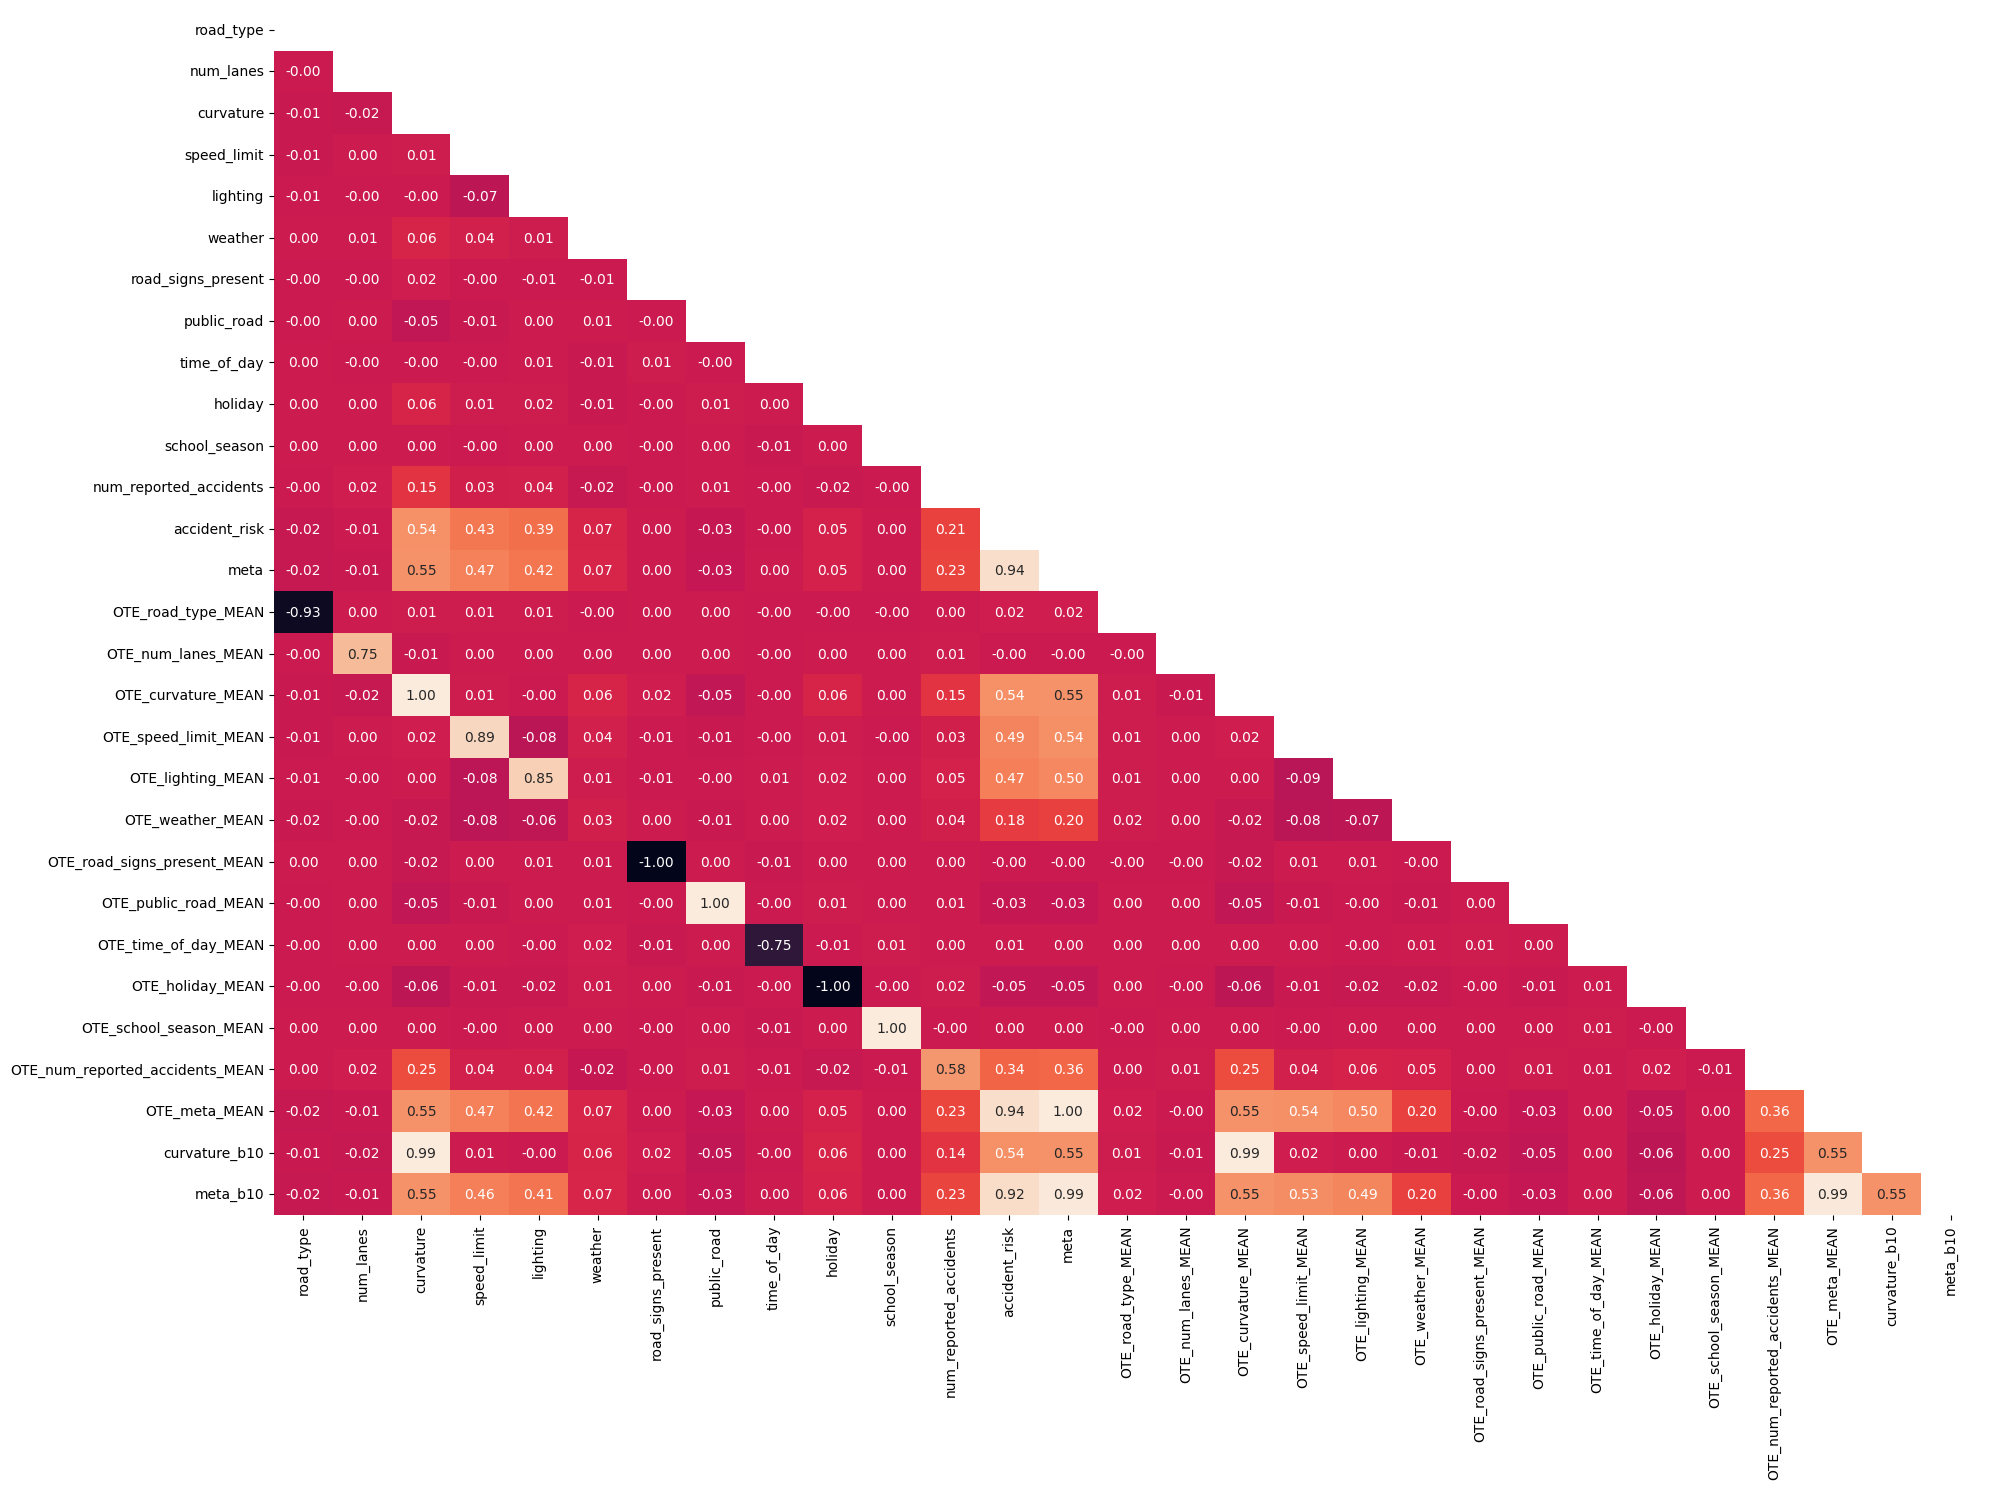

In [15]:
## -- Heatmap Plot --
plt.figure(figsize=(20, 15))
sns.heatmap(train.corr(), mask=np.triu(train.corr()), annot=True, fmt='.2f', cbar=False)
plt.tight_layout()
plt.show()

In [16]:
# -- Pairwise combinations --
TE2 = []
# COLS = [c for c in FEATURES if c not in BINARY_COLS]
for c in tqdm(list(combinations(FEATURES+BINS, 2)), desc="Creating Pairwise"):
    n = f'TE2_'+'-|-'.join(c)
    train[n] = train[c[0]].astype(str) + '_' + train[c[1]].astype(str)
    test[n]  = test[c[0]].astype(str) + '_' + test[c[1]].astype(str)
    train[n] = train[n].astype('category')
    cat = train[n].cat
    # train[n] = train[n].cat.codes
    test[n]  = pd.Categorical(test[n], categories=cat.categories)#.codes
    TE2.append(n)

Creating Pairwise:   0%|          | 0/105 [00:00<?, ?it/s]

In [17]:
## -- Triplewise combinations --
TOP_PREDICTORS = ['meta','curvature','lighting','speed_limit','weather','num_reported_accidents']
TE3 = []
for c in tqdm(list(combinations(TOP_PREDICTORS, 3)), desc="Creating Triplewise"):
    n = f'TE3_'+'-|-'.join(c)
    train[n] = train[c[0]].astype(str) + '_' + \
               train[c[1]].astype(str) + '_' + \
               train[c[2]].astype(str)
    test[n]  = test[c[0]].astype(str) + '_' + \
               test[c[1]].astype(str) + '_' + \
               test[c[2]].astype(str)

    train[n] = train[n].astype('category')
    cat = train[n].cat
    # train[n] = train[n].cat.codes
    test[n] = pd.Categorical(test[n], categories=cat.categories)#.codes
    TE3.append(n)

Creating Triplewise:   0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
len(TE2), len(TE3)

(105, 20)

In [19]:
__ = [c for c in train.columns if train[c].nunique() < 2]
print(f"Produced {len(__)} single value features: {__}")
train = train.drop(__, axis=1)
test = test.drop(__, axis=1)
print(f"Drop {len(__)} columns... Complete!")

Produced 0 single value features: []
Drop 0 columns... Complete!


In [20]:
display(train.head())
# display(train.info())
train.shape, test.shape

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,meta,OTE_road_type_MEAN,OTE_num_lanes_MEAN,OTE_curvature_MEAN,OTE_speed_limit_MEAN,OTE_lighting_MEAN,OTE_weather_MEAN,OTE_road_signs_present_MEAN,OTE_public_road_MEAN,OTE_time_of_day_MEAN,OTE_holiday_MEAN,OTE_school_season_MEAN,OTE_num_reported_accidents_MEAN,OTE_meta_MEAN,curvature_b10,meta_b10,TE2_num_lanes-|-curvature,TE2_num_lanes-|-speed_limit,TE2_num_lanes-|-num_reported_accidents,TE2_num_lanes-|-road_type,TE2_num_lanes-|-lighting,TE2_num_lanes-|-weather,TE2_num_lanes-|-road_signs_present,TE2_num_lanes-|-public_road,TE2_num_lanes-|-time_of_day,TE2_num_lanes-|-holiday,TE2_num_lanes-|-school_season,TE2_num_lanes-|-meta,TE2_num_lanes-|-curvature_b10,TE2_num_lanes-|-meta_b10,TE2_curvature-|-speed_limit,TE2_curvature-|-num_reported_accidents,TE2_curvature-|-road_type,TE2_curvature-|-lighting,TE2_curvature-|-weather,TE2_curvature-|-road_signs_present,TE2_curvature-|-public_road,TE2_curvature-|-time_of_day,TE2_curvature-|-holiday,TE2_curvature-|-school_season,TE2_curvature-|-meta,TE2_curvature-|-curvature_b10,TE2_curvature-|-meta_b10,TE2_speed_limit-|-num_reported_accidents,TE2_speed_limit-|-road_type,TE2_speed_limit-|-lighting,TE2_speed_limit-|-weather,TE2_speed_limit-|-road_signs_present,TE2_speed_limit-|-public_road,TE2_speed_limit-|-time_of_day,TE2_speed_limit-|-holiday,TE2_speed_limit-|-school_season,TE2_speed_limit-|-meta,TE2_speed_limit-|-curvature_b10,TE2_speed_limit-|-meta_b10,TE2_num_reported_accidents-|-road_type,TE2_num_reported_accidents-|-lighting,TE2_num_reported_accidents-|-weather,TE2_num_reported_accidents-|-road_signs_present,TE2_num_reported_accidents-|-public_road,TE2_num_reported_accidents-|-time_of_day,TE2_num_reported_accidents-|-holiday,TE2_num_reported_accidents-|-school_season,TE2_num_reported_accidents-|-meta,TE2_num_reported_accidents-|-curvature_b10,TE2_num_reported_accidents-|-meta_b10,TE2_road_type-|-lighting,TE2_road_type-|-weather,TE2_road_type-|-road_signs_present,TE2_road_type-|-public_road,TE2_road_type-|-time_of_day,TE2_road_type-|-holiday,TE2_road_type-|-school_season,TE2_road_type-|-meta,TE2_road_type-|-curvature_b10,TE2_road_type-|-meta_b10,TE2_lighting-|-weather,TE2_lighting-|-road_signs_present,TE2_lighting-|-public_road,TE2_lighting-|-time_of_day,TE2_lighting-|-holiday,TE2_lighting-|-school_season,TE2_lighting-|-meta,TE2_lighting-|-curvature_b10,TE2_lighting-|-meta_b10,TE2_weather-|-road_signs_present,TE2_weather-|-public_road,TE2_weather-|-time_of_day,TE2_weather-|-holiday,TE2_weather-|-school_season,TE2_weather-|-meta,TE2_weather-|-curvature_b10,TE2_weather-|-meta_b10,TE2_road_signs_present-|-public_road,TE2_road_signs_present-|-time_of_day,TE2_road_signs_present-|-holiday,TE2_road_signs_present-|-school_season,TE2_road_signs_present-|-meta,TE2_road_signs_present-|-curvature_b10,TE2_road_signs_present-|-meta_b10,TE2_public_road-|-time_of_day,TE2_public_road-|-holiday,TE2_public_road-|-school_season,TE2_public_road-|-meta,TE2_public_road-|-curvature_b10,TE2_public_road-|-meta_b10,TE2_time_of_day-|-holiday,TE2_time_of_day-|-school_season,TE2_time_of_day-|-meta,TE2_time_of_day-|-curvature_b10,TE2_time_of_day-|-meta_b10,TE2_holiday-|-school_season,TE2_holiday-|-meta,TE2_holiday-|-curvature_b10,TE2_holiday-|-meta_b10,TE2_school_season-|-meta,TE2_school_season-|-curvature_b10,TE2_school_season-|-meta_b10,TE2_meta-|-curvature_b10,TE2_meta-|-meta_b10,TE2_curvature_b10-|-meta_b10,TE3_meta-|-curvature-|-lighting,TE3_meta-|-curvature-|-speed_limit,TE3_meta-|-curvature-|-weather,TE3_meta-|-curvature-|-num_reported_accidents,TE3_meta-|-lighting-|-speed_limit,TE3_meta-|-lighting-|-weather,TE3_meta-|-lighting-|-num_reported_accidents,TE3_meta-|-speed_limit-|-weather,TE3_meta-|-speed_limit-|-num_reported_accidents,TE3_meta-|-weather-|-num_reported_accidents,TE3_curvature-|-lighting-|-speed_limit,TE3_curvature-|-lighting-|-weather,TE3_curva

((517754, 154), (172585, 153))

In [21]:
# ## -- CREATE FEATURES -- ##
# def create_features(train_df, test_df, orig_df):
#     train = train_df.copy()
#     test = test_df.copy()
#     orig = orig_df.copy()

#     ## -- meta feature --
#     BINARY_COLS = [c for c in test.columns if test[c].nunique() == 2]
#     for df in [train, test, orig]:
#         base_risk = (
#             0.3 * df["curvature"] +
#             0.2 * (df["lighting"] == "night").astype(int) +
#             0.1 * (df["weather"] != "clear").astype(int) +
#             0.2 * (df["speed_limit"] >= 60).astype(int) +
#             0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
#                 )
#         df['meta'] = base_risk

#         df['BINARY'] = 0
#         for i in range(len(BINARY_COLS)):
#             df['BINARY'] += df[BINARY_COLS[i]].astype(int) * (2**i)

#     print(f"✅ 'meta' feature created!")
#     print(f"✅ 'BINARY' feature created!")

#     DIGITS = []
#     for c in ['curvature', 'speed_limit']: # only features with > 1 digits
#         for i in range(-3, 3):
#             n = f"{c}_{i}"
#             train[n] = ((train[c] * 10**i) % 10).astype("int8")
#             test[n]  = ((test[c] * 10**i) % 10).astype("int8")
#             orig[n]  = ((orig[c] * 10**i) % 10).astype("int8")
#             if train[n].nunique()==1:
#                 train = train.drop([n], axis=1)
#                 test  = test.drop([n], axis=1)
#                 orig  = orig.drop([n], axis=1)
#             else:
#                 DIGITS.append(n)
#     print(f"✅  Digits extract features: {len(DIGITS)}")
#     for col in DIGITS:
#         print(f"{col}: {train[col].nunique()} unique values")

#     ## -- Use original aggregated features --
#     FEAT = [c for c in test.columns if c not in BINARY_COLS] # Exclude binned features
#     print(f"Merging {len(FEAT)} features: ", end="")
#     STATS = ['mean','count'] # ,'nunique','max','min',
#     for c in FEAT:
#         print(f"{c}, ", end="")
#         tmp = orig.groupby(c)[TARGET].agg(STATS)
#         tmp.columns = [f'OTE_{c}_{s.upper()}' for s in STATS]
#         train = train.merge(tmp, on=c, how='left')
#         test  = test.merge(tmp, on=c, how='left')
#     print()

#     BINS = []
#     print(f"\nCreating bins... ", end="")
#     for c in ['curvature', 'meta']: # <- add feature 1 after the other
#         for b in [5, 10]:
#             print(f"{c}_{b}, ", end="")
#             b_n = f'{c}_b{b}'
#             # Fit on train data and transform both train and test
#             bins = np.linspace(train[c].min(), train[c].max(), b+1)
#             train[b_n] = pd.cut(train[c], include_lowest=True, labels=False, bins=bins)
#             test[b_n] = pd.cut(test[c], include_lowest=True, labels=False, bins=bins)
#             BINS.append(b_n)
#     print()
#     print(f"✅ {len(BINS)} binned features created!")

#     ## -- Factorize using combined data to ensure consistent mapping --
#     BOOLS = train.select_dtypes(include=bool).columns
#     for c in CATS:
#         if c not in BOOLS:
#             combined = pd.concat([train[c], test[c]], axis=0)
#             combined = combined.factorize()[0]
#             train[c] = combined[:len(train)].astype("int32")
#             test[c]  = combined[len(train):].astype("int32")

#     ## -- Polynomials --
#     for df in [train, test]:
#         df['curvature_sqrt'] = np.sqrt(df['curvature']) #Square-root
#         df['curvature_squared'] = df['curvature'] ** 2 #Squared
#         df['curvature_cubed'] = df['curvature'] ** 3 #Cubed
#         df['curve-+-speed-+-light'] = df[['curvature', 'speed_limit', 'lighting']].sum(axis=1)
#     print(f"✅ Polynomial features created!")

#     ## -- Pairwise combinations --
#     TE = []
#     for n in [2]:
#         for cols in tqdm(list(combinations(FEATURES+BINS+DIGITS+['BINARY'], n)), desc="Creating Pairwise"):
#             name = '-|-'.join(sorted(cols))
#             train[name] = train[cols[0]].astype(str) + '_' + train[cols[1]].astype(str)
#             test[name] = test[cols[0]].astype(str) + '_' + test[cols[1]].astype(str)
#             train[name] = train[name].astype('category')
#             cat = train[name].cat
#             train[name] = train[name].cat.codes
#             test[name] = pd.Categorical(test[name], categories=cat.categories).codes
#             TE.append(name)

#     ## -- Triplewise combinations --
#     TOP_PREDICTORS = ['curvature','lighting','speed_limit','weather','num_reported_accidents']
#     for n in [3]:
#         for cols in tqdm(list(combinations(TOP_PREDICTORS, n)), desc="Creating Triplewise"):
#             nm = '-|-'.join(sorted(cols))
#             train[nm] = train[cols[0]].astype(str) + '_' + \
#                         train[cols[1]].astype(str) + '_' + \
#                         train[cols[2]].astype(str)
#             test[nm]  = test[cols[0]].astype(str) + '_' + \
#                         test[cols[1]].astype(str) + '_' + \
#                         test[cols[2]].astype(str)
#             train[nm] = train[nm].astype('category')
#             cat = train[nm].cat
#             train[nm] = train[nm].cat.codes
#             test[nm] = pd.Categorical(test[nm], categories=cat.categories).codes
#             TE.append(nm)

#     print(f"✅ Interations (TE) created: {len(TE)}")
#     print(f"✅ Binned features (BINS): {len(BINS)}")
#     print(f"{COLOR}{'='*50}")
#     print(f"ℹ️ Feature Engineering Complete!")
#     print(f"ℹ️ Total features: {len(test.columns)}")
#     print(f"{'='*50}")

#     return train, test, TE, BINS, DIGITS

In [22]:
# train, test, TE, BINS, DIGITS = create_features(train, test, orig)

In [23]:
display(train.head())
# display(train.info())
train.shape, test.shape

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,meta,OTE_road_type_MEAN,OTE_num_lanes_MEAN,OTE_curvature_MEAN,OTE_speed_limit_MEAN,OTE_lighting_MEAN,OTE_weather_MEAN,OTE_road_signs_present_MEAN,OTE_public_road_MEAN,OTE_time_of_day_MEAN,OTE_holiday_MEAN,OTE_school_season_MEAN,OTE_num_reported_accidents_MEAN,OTE_meta_MEAN,curvature_b10,meta_b10,TE2_num_lanes-|-curvature,TE2_num_lanes-|-speed_limit,TE2_num_lanes-|-num_reported_accidents,TE2_num_lanes-|-road_type,TE2_num_lanes-|-lighting,TE2_num_lanes-|-weather,TE2_num_lanes-|-road_signs_present,TE2_num_lanes-|-public_road,TE2_num_lanes-|-time_of_day,TE2_num_lanes-|-holiday,TE2_num_lanes-|-school_season,TE2_num_lanes-|-meta,TE2_num_lanes-|-curvature_b10,TE2_num_lanes-|-meta_b10,TE2_curvature-|-speed_limit,TE2_curvature-|-num_reported_accidents,TE2_curvature-|-road_type,TE2_curvature-|-lighting,TE2_curvature-|-weather,TE2_curvature-|-road_signs_present,TE2_curvature-|-public_road,TE2_curvature-|-time_of_day,TE2_curvature-|-holiday,TE2_curvature-|-school_season,TE2_curvature-|-meta,TE2_curvature-|-curvature_b10,TE2_curvature-|-meta_b10,TE2_speed_limit-|-num_reported_accidents,TE2_speed_limit-|-road_type,TE2_speed_limit-|-lighting,TE2_speed_limit-|-weather,TE2_speed_limit-|-road_signs_present,TE2_speed_limit-|-public_road,TE2_speed_limit-|-time_of_day,TE2_speed_limit-|-holiday,TE2_speed_limit-|-school_season,TE2_speed_limit-|-meta,TE2_speed_limit-|-curvature_b10,TE2_speed_limit-|-meta_b10,TE2_num_reported_accidents-|-road_type,TE2_num_reported_accidents-|-lighting,TE2_num_reported_accidents-|-weather,TE2_num_reported_accidents-|-road_signs_present,TE2_num_reported_accidents-|-public_road,TE2_num_reported_accidents-|-time_of_day,TE2_num_reported_accidents-|-holiday,TE2_num_reported_accidents-|-school_season,TE2_num_reported_accidents-|-meta,TE2_num_reported_accidents-|-curvature_b10,TE2_num_reported_accidents-|-meta_b10,TE2_road_type-|-lighting,TE2_road_type-|-weather,TE2_road_type-|-road_signs_present,TE2_road_type-|-public_road,TE2_road_type-|-time_of_day,TE2_road_type-|-holiday,TE2_road_type-|-school_season,TE2_road_type-|-meta,TE2_road_type-|-curvature_b10,TE2_road_type-|-meta_b10,TE2_lighting-|-weather,TE2_lighting-|-road_signs_present,TE2_lighting-|-public_road,TE2_lighting-|-time_of_day,TE2_lighting-|-holiday,TE2_lighting-|-school_season,TE2_lighting-|-meta,TE2_lighting-|-curvature_b10,TE2_lighting-|-meta_b10,TE2_weather-|-road_signs_present,TE2_weather-|-public_road,TE2_weather-|-time_of_day,TE2_weather-|-holiday,TE2_weather-|-school_season,TE2_weather-|-meta,TE2_weather-|-curvature_b10,TE2_weather-|-meta_b10,TE2_road_signs_present-|-public_road,TE2_road_signs_present-|-time_of_day,TE2_road_signs_present-|-holiday,TE2_road_signs_present-|-school_season,TE2_road_signs_present-|-meta,TE2_road_signs_present-|-curvature_b10,TE2_road_signs_present-|-meta_b10,TE2_public_road-|-time_of_day,TE2_public_road-|-holiday,TE2_public_road-|-school_season,TE2_public_road-|-meta,TE2_public_road-|-curvature_b10,TE2_public_road-|-meta_b10,TE2_time_of_day-|-holiday,TE2_time_of_day-|-school_season,TE2_time_of_day-|-meta,TE2_time_of_day-|-curvature_b10,TE2_time_of_day-|-meta_b10,TE2_holiday-|-school_season,TE2_holiday-|-meta,TE2_holiday-|-curvature_b10,TE2_holiday-|-meta_b10,TE2_school_season-|-meta,TE2_school_season-|-curvature_b10,TE2_school_season-|-meta_b10,TE2_meta-|-curvature_b10,TE2_meta-|-meta_b10,TE2_curvature_b10-|-meta_b10,TE3_meta-|-curvature-|-lighting,TE3_meta-|-curvature-|-speed_limit,TE3_meta-|-curvature-|-weather,TE3_meta-|-curvature-|-num_reported_accidents,TE3_meta-|-lighting-|-speed_limit,TE3_meta-|-lighting-|-weather,TE3_meta-|-lighting-|-num_reported_accidents,TE3_meta-|-speed_limit-|-weather,TE3_meta-|-speed_limit-|-num_reported_accidents,TE3_meta-|-weather-|-num_reported_accidents,TE3_curvature-|-lighting-|-speed_limit,TE3_curvature-|-lighting-|-weather,TE3_curva

((517754, 154), (172585, 153))

### MODEL TRAINING

In [24]:
## -- DEFINE TRAINING PARAMETERS --
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true.values, y_pred))

# params = dict(
#     grow_policy = "depthwise",
#     objective = "reg:squarederror",
#     eval_metric = "rmse",
#     eta = 0.005,
#     max_depth = 7,
#     min_child_weight = 50,
#     subsample = 0.9,
#     colsample_bytree = 0.4,
#     n_jobs = -1,
#     device = "cpu",
# )

params = dict(
    grow_policy = "lossguide",
    objective = "reg:squarederror",
    eval_metric = "rmse",
    eta = 0.005,
    max_depth = 7,
    max_leaves = 70,
    min_child_weight = 50,
    reg_lambda = 0.1,
    subsample = 0.9,
    colsample_bytree = 0.4,
    n_jobs = -1,
    device = "cpu",
)

ℹ️ Device: CPU 4 cores
|---------------------------------
	Fold 1 #####


Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

[0]	train-rmse:0.16572	valid-rmse:0.16544
[200]	train-rmse:0.08025	valid-rmse:0.07985
[400]	train-rmse:0.05988	valid-rmse:0.05968
[600]	train-rmse:0.05644	valid-rmse:0.05644
[800]	train-rmse:0.05585	valid-rmse:0.05598
[1000]	train-rmse:0.05569	valid-rmse:0.05591
[1200]	train-rmse:0.05559	valid-rmse:0.05589
[1400]	train-rmse:0.05551	valid-rmse:0.05588
[1600]	train-rmse:0.05545	valid-rmse:0.05587
[1800]	train-rmse:0.05539	valid-rmse:0.05587
[2000]	train-rmse:0.05533	valid-rmse:0.05586
[2200]	train-rmse:0.05527	valid-rmse:0.05586
[2400]	train-rmse:0.05521	valid-rmse:0.05586
[2600]	train-rmse:0.05515	valid-rmse:0.05586
[2800]	train-rmse:0.05510	valid-rmse:0.05586
[3000]	train-rmse:0.05505	valid-rmse:0.05586
[3200]	train-rmse:0.05499	valid-rmse:0.05585
[3400]	train-rmse:0.05494	valid-rmse:0.05585
[3600]	train-rmse:0.05489	valid-rmse:0.05585
[3800]	train-rmse:0.05483	valid-rmse:0.05585
[4000]	train-rmse:0.05478	valid-rmse:0.05585
[4200]	train-rmse:0.05473	valid-rmse:0.05585
[4400]	train-rmse

Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

[0]	train-rmse:0.16576	valid-rmse:0.16520
[200]	train-rmse:0.08020	valid-rmse:0.08027
[400]	train-rmse:0.05979	valid-rmse:0.06027
[600]	train-rmse:0.05635	valid-rmse:0.05701
[800]	train-rmse:0.05576	valid-rmse:0.05653
[1000]	train-rmse:0.05559	valid-rmse:0.05645
[1200]	train-rmse:0.05550	valid-rmse:0.05643
[1400]	train-rmse:0.05542	valid-rmse:0.05641
[1600]	train-rmse:0.05535	valid-rmse:0.05641
[1800]	train-rmse:0.05530	valid-rmse:0.05640
[2000]	train-rmse:0.05524	valid-rmse:0.05640
[2200]	train-rmse:0.05518	valid-rmse:0.05640
[2400]	train-rmse:0.05513	valid-rmse:0.05640
[2600]	train-rmse:0.05507	valid-rmse:0.05639
[2800]	train-rmse:0.05502	valid-rmse:0.05639
[3000]	train-rmse:0.05496	valid-rmse:0.05639
[3200]	train-rmse:0.05491	valid-rmse:0.05639
[3400]	train-rmse:0.05486	valid-rmse:0.05639
[3600]	train-rmse:0.05481	valid-rmse:0.05639
[3800]	train-rmse:0.05475	valid-rmse:0.05639
[4000]	train-rmse:0.05470	valid-rmse:0.05639
[4200]	train-rmse:0.05465	valid-rmse:0.05638
[4400]	train-rmse

Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

[0]	train-rmse:0.16560	valid-rmse:0.16619
[200]	train-rmse:0.08022	valid-rmse:0.08012
[400]	train-rmse:0.05988	valid-rmse:0.05970
[600]	train-rmse:0.05645	valid-rmse:0.05637
[800]	train-rmse:0.05587	valid-rmse:0.05588
[1000]	train-rmse:0.05570	valid-rmse:0.05579
[1200]	train-rmse:0.05560	valid-rmse:0.05577
[1400]	train-rmse:0.05552	valid-rmse:0.05576
[1600]	train-rmse:0.05546	valid-rmse:0.05576
[1800]	train-rmse:0.05540	valid-rmse:0.05575
[2000]	train-rmse:0.05534	valid-rmse:0.05575
[2200]	train-rmse:0.05529	valid-rmse:0.05575
[2400]	train-rmse:0.05523	valid-rmse:0.05575
[2600]	train-rmse:0.05518	valid-rmse:0.05575
[2800]	train-rmse:0.05512	valid-rmse:0.05575
[3000]	train-rmse:0.05507	valid-rmse:0.05575
[3200]	train-rmse:0.05502	valid-rmse:0.05575
[3400]	train-rmse:0.05497	valid-rmse:0.05575
[3600]	train-rmse:0.05491	valid-rmse:0.05575
[3760]	train-rmse:0.05487	valid-rmse:0.05575
	Model RMSE:0.055747
|---------------------------------
	Fold 4 #####


Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

[0]	train-rmse:0.16563	valid-rmse:0.16600
[200]	train-rmse:0.08021	valid-rmse:0.08023
[400]	train-rmse:0.05984	valid-rmse:0.05997
[600]	train-rmse:0.05640	valid-rmse:0.05669
[800]	train-rmse:0.05581	valid-rmse:0.05622
[1000]	train-rmse:0.05564	valid-rmse:0.05614
[1200]	train-rmse:0.05554	valid-rmse:0.05612
[1400]	train-rmse:0.05546	valid-rmse:0.05611
[1600]	train-rmse:0.05539	valid-rmse:0.05610
[1800]	train-rmse:0.05533	valid-rmse:0.05610
[2000]	train-rmse:0.05527	valid-rmse:0.05609
[2200]	train-rmse:0.05521	valid-rmse:0.05609
[2400]	train-rmse:0.05516	valid-rmse:0.05609
[2600]	train-rmse:0.05510	valid-rmse:0.05609
[2800]	train-rmse:0.05504	valid-rmse:0.05609
[3000]	train-rmse:0.05499	valid-rmse:0.05609
[3200]	train-rmse:0.05494	valid-rmse:0.05609
[3222]	train-rmse:0.05493	valid-rmse:0.05609
	Model RMSE:0.056091
|---------------------------------
	Fold 5 #####


Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

[0]	train-rmse:0.16571	valid-rmse:0.16548
[200]	train-rmse:0.08023	valid-rmse:0.07999
[400]	train-rmse:0.05985	valid-rmse:0.05980
[600]	train-rmse:0.05641	valid-rmse:0.05654
[800]	train-rmse:0.05583	valid-rmse:0.05607
[1000]	train-rmse:0.05566	valid-rmse:0.05599
[1200]	train-rmse:0.05557	valid-rmse:0.05597
[1400]	train-rmse:0.05549	valid-rmse:0.05596
[1600]	train-rmse:0.05543	valid-rmse:0.05596
[1800]	train-rmse:0.05537	valid-rmse:0.05596
[2000]	train-rmse:0.05532	valid-rmse:0.05596
[2200]	train-rmse:0.05526	valid-rmse:0.05596
[2400]	train-rmse:0.05521	valid-rmse:0.05596
[2600]	train-rmse:0.05515	valid-rmse:0.05596
[2800]	train-rmse:0.05510	valid-rmse:0.05596
[3000]	train-rmse:0.05504	valid-rmse:0.05596
[3018]	train-rmse:0.05504	valid-rmse:0.05596
	Model RMSE:0.055956
|---------------------------------
	Fold 6 #####


Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

[0]	train-rmse:0.16563	valid-rmse:0.16599
[200]	train-rmse:0.08021	valid-rmse:0.08015
[400]	train-rmse:0.05985	valid-rmse:0.05983
[600]	train-rmse:0.05642	valid-rmse:0.05654
[800]	train-rmse:0.05583	valid-rmse:0.05606
[1000]	train-rmse:0.05567	valid-rmse:0.05597
[1200]	train-rmse:0.05557	valid-rmse:0.05595
[1400]	train-rmse:0.05549	valid-rmse:0.05594
[1600]	train-rmse:0.05542	valid-rmse:0.05593
[1800]	train-rmse:0.05536	valid-rmse:0.05593
[2000]	train-rmse:0.05530	valid-rmse:0.05592
[2200]	train-rmse:0.05525	valid-rmse:0.05592
[2400]	train-rmse:0.05519	valid-rmse:0.05592
[2600]	train-rmse:0.05513	valid-rmse:0.05592
[2800]	train-rmse:0.05508	valid-rmse:0.05592
[3000]	train-rmse:0.05503	valid-rmse:0.05592
[3200]	train-rmse:0.05498	valid-rmse:0.05591
[3400]	train-rmse:0.05492	valid-rmse:0.05591
[3486]	train-rmse:0.05490	valid-rmse:0.05591
	Model RMSE:0.055914
|---------------------------------
	Fold 7 #####


Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

[0]	train-rmse:0.16572	valid-rmse:0.16546
[200]	train-rmse:0.08026	valid-rmse:0.07987
[400]	train-rmse:0.05989	valid-rmse:0.05963
[600]	train-rmse:0.05645	valid-rmse:0.05636
[800]	train-rmse:0.05586	valid-rmse:0.05589
[1000]	train-rmse:0.05569	valid-rmse:0.05581
[1200]	train-rmse:0.05560	valid-rmse:0.05579
[1400]	train-rmse:0.05552	valid-rmse:0.05578
[1600]	train-rmse:0.05546	valid-rmse:0.05578
[1800]	train-rmse:0.05540	valid-rmse:0.05577
[2000]	train-rmse:0.05535	valid-rmse:0.05577
[2200]	train-rmse:0.05529	valid-rmse:0.05577
[2400]	train-rmse:0.05523	valid-rmse:0.05577
[2600]	train-rmse:0.05518	valid-rmse:0.05577
[2800]	train-rmse:0.05512	valid-rmse:0.05577
[3000]	train-rmse:0.05507	valid-rmse:0.05577
[3200]	train-rmse:0.05502	valid-rmse:0.05577
[3400]	train-rmse:0.05496	valid-rmse:0.05577
[3474]	train-rmse:0.05495	valid-rmse:0.05577
	Model RMSE:0.055765
|--------------------------------------------------
| No.Total features: 153
| Overall OOF  RMSE: 0.055959
| Average Fold RMSE: 0.0

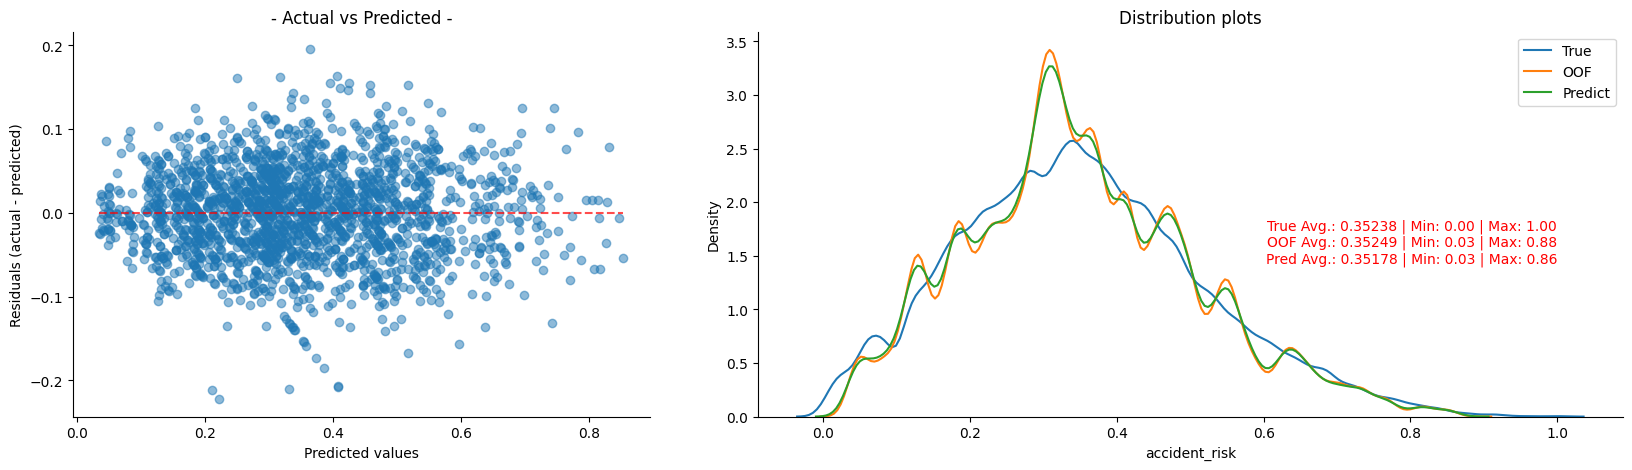

Training Time: 79.57 mins =========================


In [25]:
## -- DEFINE TRAINING PARAMETERS --
if torch.cuda.is_available():
    print(f"ℹ️ Device GPU: {torch.cuda.get_device_name(0)}")
    print(f"ℹ️ No. of CPU: {os.cpu_count()} cores")
else:
    print(f"ℹ️ Device: CPU {os.cpu_count()} cores")
## -----------------------------------------------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true.values, y_pred))

oof_preds   = np.zeros(len(train))
test_preds  = np.zeros(len(test))
fold_scores = []

X = train.drop(TARGET, axis=1)
y = train[TARGET]

FOLDS = 7
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
rand_seeds = np.ceil(np.linspace(SEED, 2005, FOLDS)).astype(int)

## -- Initiate Training -- 
tik = time()
for fold, (t_idx, v_idx) in enumerate(kf.split(X)):
    print(f"|{'-'*33}")
    print(f"\t{COLOR}Fold {fold+1} {'#'*5}{RESET}")

    X_train, X_val = X.iloc[t_idx], X.iloc[v_idx]
    y_train, y_val = y.iloc[t_idx], y.iloc[v_idx]

    X_train_enc = X_train.copy()
    X_val_enc   = X_val.copy()
    test_enc    = test.copy()

    ## -- Target Encoding --
    for col in tqdm(TE2+TE3, desc="Target Encoding", leave=False):
        if torch.cuda.is_available(): # -> GPU
            TE_enc = cuTE(n_folds=5, smooth=5, split_method='random')
        else: # -> CPU
            TE_enc = sciTE(cv=5, smooth=10, random_state=SEED)
            # TE_enc = ceTE(cols=[col], smoothing=5)
        X_train_enc[col] = TE_enc.fit_transform(X_train_enc[[col]], y_train).astype('float32')
        X_val_enc[col]   = TE_enc.transform(X_val_enc[[col]]).astype('float32')
        test_enc[col]    = TE_enc.transform(test_enc[[col]]).astype('float32')

    X_train_enc[CATS] = X_train_enc[CATS].astype("category")
    X_val_enc[CATS]   = X_val_enc[CATS].astype("category")
    test_enc[CATS]    = test_enc[CATS].astype("category")

    params['seed'] = rand_seeds[fold]
    
    ## -- Create DMatrix objects --
    dtrain = xgb.DMatrix(X_train_enc, y_train, enable_categorical=True)
    dval   = xgb.DMatrix(X_val_enc, y_val, enable_categorical=True)
    dtest  = xgb.DMatrix(test_enc, enable_categorical=True)

    model = xgb.train( 
        params,
        dtrain,
        num_boost_round = 10000,
        evals = [(dtrain, "train"), (dval, "valid")],
        early_stopping_rounds = 300,
        verbose_eval = 200,
    )

    y_pred = model.predict(dval, iteration_range=(0, model.best_iteration + 1))
    oof_preds[v_idx] = np.clip(y_pred, 0, 1)
    predictions = model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
    test_preds += np.clip(predictions, 0, 1) / FOLDS
    
    ## -- Get score for validation fold --
    print(f"\t{COLOR}Model RMSE:{model.best_score:.6f}{RESET}")
    fold_scores.append(model.best_score)

    sleep(2); gc.collect(); sleep(2) # Rest. Clean. Repeat.

## -- After all folds --
overall_score = rmse(y, oof_preds)
print(f"|{'-'*50}{COLOR}")
print(f"| No.Total features: {len(X_train_enc.columns)}")
print(f"| Overall OOF  RMSE: {overall_score:.6f}")
print(f"| Average Fold RMSE: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}{RESET}")

## -- Plot predictions errors --
GRID_ = dict(width_ratios=[0.4, 0.6], wspace=0.15)
fig, axs = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw=GRID_)
display = PredictionErrorDisplay.from_predictions(
                y, oof_preds, ax=axs[0], subsample=2000,
                # kind = "actual_vs_predicted",
                scatter_kwargs={"alpha": 0.5}, line_kwargs={'color': 'r'},
        )
axs[0].set_title(f"- Actual vs Predicted -")

LABELS = ['True', 'OOF', 'Predict']
TEXT = f"""
True Avg.: {np.mean(y):.5f} | Min: {np.min(y):.2f} | Max: {np.max(y):.2f}
OOF Avg.: {np.mean(oof_preds):.5f} | Min: {np.min(oof_preds):.2f} | Max: {np.max(oof_preds):.2f}
Pred Avg.: {np.mean(test_preds):.5f} | Min: {np.min(test_preds):.2f} | Max: {np.max(test_preds):.2f}
        """
sns.kdeplot(y, ax=axs[1], label=LABELS[0])
sns.kdeplot(oof_preds, ax=axs[1], label=LABELS[1])
sns.kdeplot(test_preds, ax=axs[1], label=LABELS[2])
axs[1].set_title(f"Distribution plots")
axs[1].text(x=1, y=2, s=TEXT, ha='right', va='top', color='r')

for ax in axs:
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.legend()
plt.tight_layout()
plt.show()

name = f"xgbLOSS_" + f"{overall_score:.6f}".split('.')[1]
oof_final  = pd.DataFrame(oof_preds, columns=[name])
test_final = pd.DataFrame(test_preds, columns=[name])

tok = time()
tiktok = (tok-tik) / 60
print(f"Training Time: {tiktok:.2f} mins {'='*25}")

In [26]:
X_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 443790 entries, 0 to 517753
Columns: 153 entries, road_type to TE3_speed_limit-|-weather-|-num_reported_accidents
dtypes: category(8), float32(125), float64(15), int64(5)
memory usage: 286.1 MB


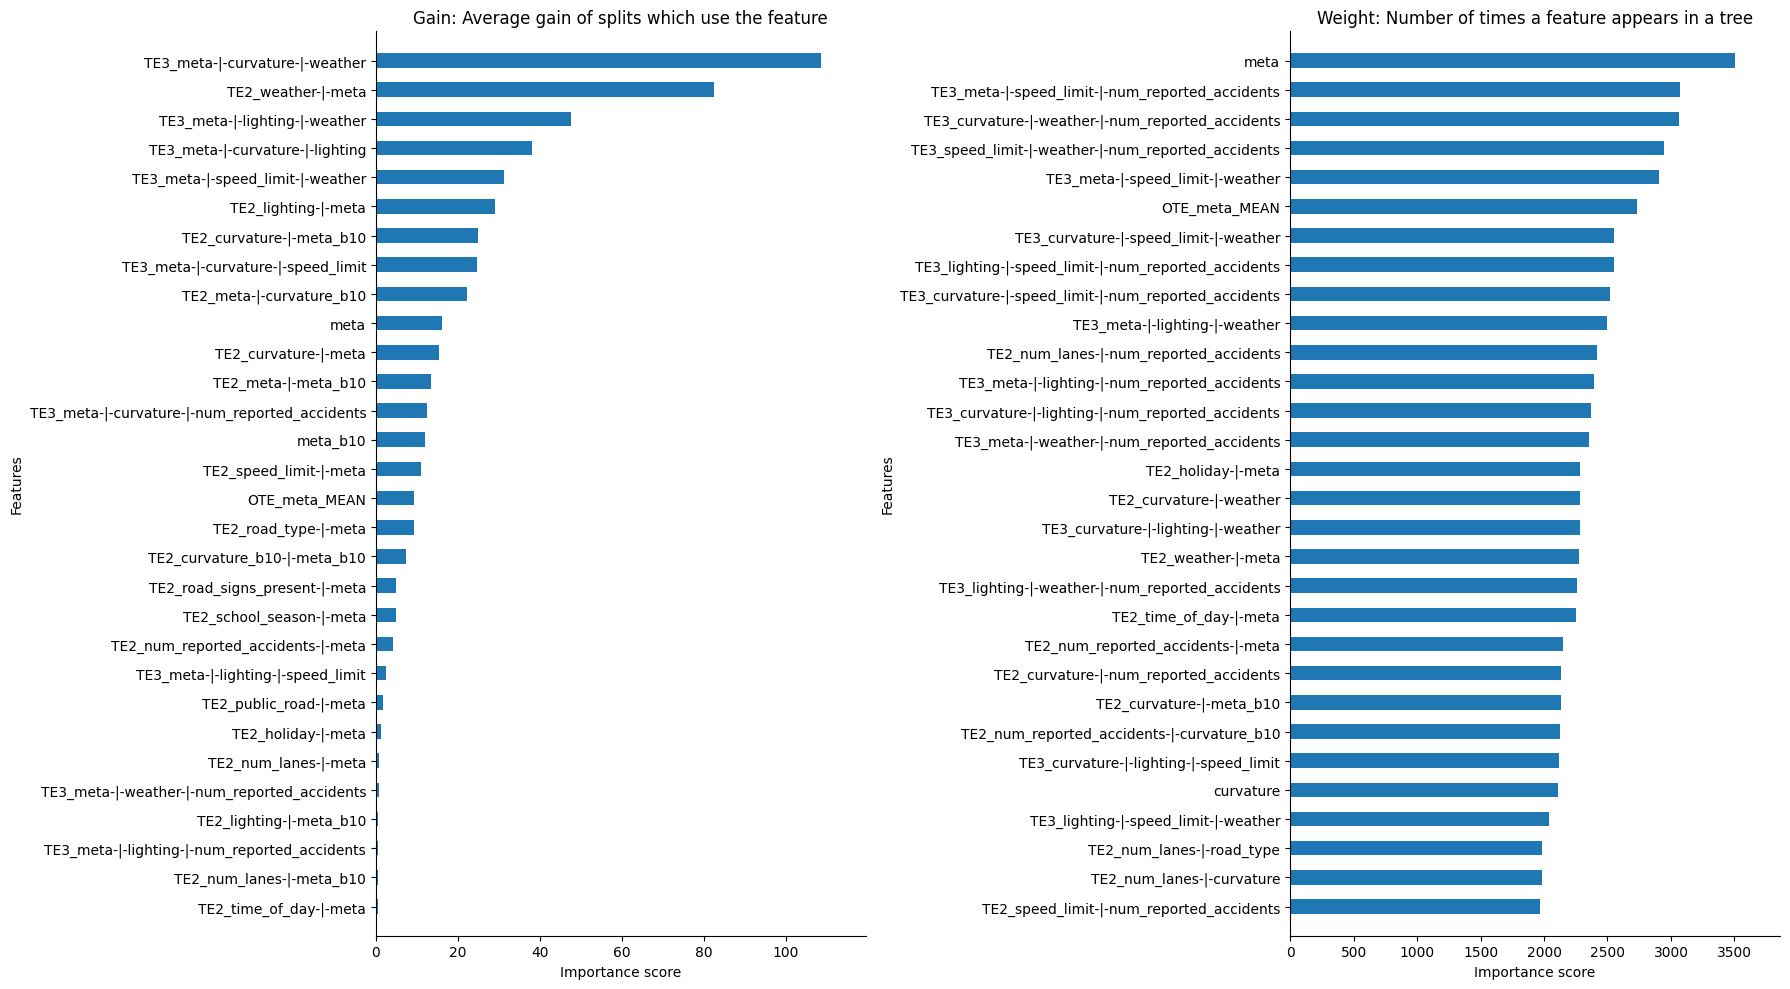

In [27]:
## -- Plot Feature Importances --
MAX = 30
_, axs = plt.subplots(1, 2, figsize=(18, 10))
xgb.plot_importance(
                    model, ax=axs[0],
                    max_num_features=MAX,
                    importance_type='gain',
                    height=0.5, show_values=False, grid=False,
                    title="Gain: Average gain of splits which use the feature"
    )
xgb.plot_importance(
                    model, ax=axs[1],
                    max_num_features=MAX, 
                    importance_type='weight',
                    height=0.5, show_values=False, grid=False,
                    title="Weight: Number of times a feature appears in a tree"
    )
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

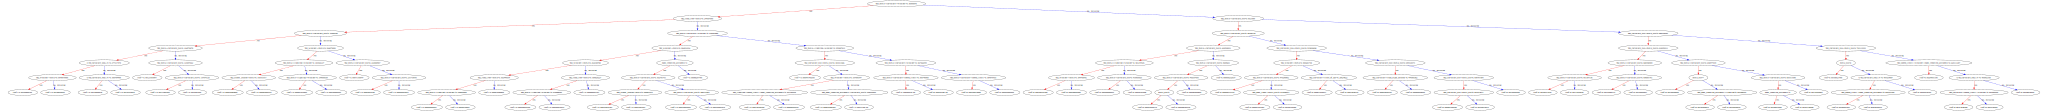

In [28]:
# _, ax = plt.subplots(1, 1, figsize=(20, 10))
# xgb.plot_tree(model, tree_idx=0, ax=ax)
# plt.show()
xgb.to_graphviz(model, tree_idx=0)

In [29]:
# ## -- Plot SHAP --
# fig, axs =  plt.subplots(1, 2, figsize=(20, 12))

# explainer = shap.TreeExplainer(model)
# explanation = explainer(X_val_enc.sample(frac=0.5, random_state=SEED))

# # Bar plot
# shap.plots.bar(explanation[0], show=False, max_display=MAX, ax=axs[0])
# axs[0].set_title("SHAP Feature Importances")
# # Beeswarm plot
# shap.plots.beeswarm(explanation, show=False, max_display=MAX, ax=axs[1],
#                     order=explanation.abs.max(0),
#                     color_bar=False, plot_size=None)
# axs[1].set_title("SHAP 30 Most Impactful Features")
# fig.suptitle(f"- XGB: SHAP Feature Importance -", fontsize=15)
# fig.tight_layout(pad=1.5)
# plt.show()

In [30]:
## -- Save OOF & PREDICTIONS --
oof_final.to_parquet(f"{name}_oof.parquet", index=False)
test_final.to_parquet(f"{name}_pred.parquet", index=False)

## -- Submission file --
submit[TARGET] = test_final.values
submit.to_csv(f"submit_{name}.csv", index=False)
submit.head()

,id,accident_risk
0,517754,0.293137
1,517755,0.120595
2,517756,0.178268
3,517757,0.313801
4,517758,0.406737


In [31]:
# @title
# ## -- GPU FORWARD FEATURE SELECTION -- ##
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# ADD  = []
# best_rmse = 0
# best_oof = None
# best_pred = None

# FOLDS = 5
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# X = train.drop(TARGET, axis=1)
# y = train[TARGET]

# # FORWARD FEATURE SELECTION
# for k, col in enumerate(['baseline']+TE_columns, start=1):
#     oof_cuRF = np.zeros(len(X))
#     pred_cuRF = np.zeros(len(test))
#     # scaler = RobustScaler()
#     encoder = ce.TargetEncoder(cols=col, smoothing=10)

#     if col != 'baseline': ADD.append(col)

#     # K-FOLD USING YEAR AS GROUP
#     for i, (train_index, test_index) in enumerate(kf.split(X)):
#         # TRAIN AND VALID DATA
#         x_train = X.loc[train_index, ['TrackDurationMs']+ADD].copy()
#         y_train = y.loc[train_index]
#         x_valid = X.loc[test_index, ['TrackDurationMs']+ADD].copy()
#         y_valid = y.loc[test_index]
#         x_test = test[['TrackDurationMs']+ADD].copy()

#         # x_train = scaler.fit_transform(x_train)
#         # x_valid = scaler.transform(x_valid)

#         if col != 'baseline':
#             encoder.fit(x_train, y_train)
#             x_train = encoder.transform(x_train)
#             x_valid = encoder.transform(x_valid)

#         # # SVC WANTS STANDARIZED FEATURES
#         # for c in ORIG_FEATURES+ADD:
#         #     m = x_train[c].mean()
#         #     s = x_train[c].std()
#         #     x_train[c] = (x_train[c]#-m)/s
#         #     x_valid[c] = (x_valid[c]#-m)/s
#         #     x_test[c] = (x_test[c]#-m)/s
#         #     x_test[c] = x_test[c]#.fillna(0)

#         # TRAIN SVC MODEL
#         # model = RandomForestClassifier()
#         model = xgb.XGBRegressor(random_state=SEED, device=USE_cud, n_estimators=200)
#         model.fit(x_train.values, y_train.values)

#         # INFER OOF
#         oof_cuRF[test_index] = model.predict(x_valid.values)
#         # INFER TEST
#         pred_cuRF += model.predict(x_test.values)

#     gc.collect()

#     # COMPUTE AVERAGE TEST PREDS
#     pred_cuRF /= FOLDS

#     # COMPUTE CV VALIDATION AUC SCORE
#     # true = y.values
#     m = rmse(y.values, oof_cuRF)

#     if m<best_rmse:
#         print(f"{k}. \033[32m ❇️ NEW_ BEST with {col} at {m:.6f}{RESET}")
#         best_auc = m
#         best_oof = oof_cuRF.copy()
#         best_pred = pred_cuRF.copy()
#     else:
#         print(f"{k}. \033[31m 🔻 NEW_WORSE with {col} at {m:.6f}{RESET}")
#         ADD.remove(col)